In [12]:
from distutils.util import strtobool
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
import maze_library
from torch.utils.tensorboard import SummaryWriter


In [13]:
DEVICE = 'cpu'

In [14]:
# Policy and value model
class ActorCriticNetwork(nn.Module):
  def __init__(self, obs_space_size, action_space_size):
    super().__init__()

    self.shared_layers = nn.Sequential(
        nn.Linear(obs_space_size, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU())
    
    self.policy_layers = nn.Sequential(
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, action_space_size))
    
    self.value_layers = nn.Sequential(
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 1))
    
  def value(self, obs):
    z = self.shared_layers(obs)
    value = self.value_layers(z)
    return value
        
  def policy(self, obs):
    z = self.shared_layers(obs)
    policy_logits = self.policy_layers(z)
    return policy_logits

  def forward(self, obs):
    z = self.shared_layers(obs)
    policy_logits = self.policy_layers(z)
    value = self.value_layers(z)
    return policy_logits, value

In [15]:
class PPOTrainer():
  def __init__(self,
              actor_critic,
              ppo_clip_val=0.2,
              target_kl_div=0.01,
              max_policy_train_iters=80,
              value_train_iters=80,
              policy_lr=3e-4,
              value_lr=1e-2):
    self.ac = actor_critic
    self.ppo_clip_val = ppo_clip_val
    self.target_kl_div = target_kl_div
    self.max_policy_train_iters = max_policy_train_iters
    self.value_train_iters = value_train_iters

    policy_params = list(self.ac.shared_layers.parameters()) + \
        list(self.ac.policy_layers.parameters())
    self.policy_optim = optim.Adam(policy_params, lr=policy_lr)

    value_params = list(self.ac.shared_layers.parameters()) + \
        list(self.ac.value_layers.parameters())
    self.value_optim = optim.Adam(value_params, lr=value_lr)

  def train_policy(self, obs, acts, old_log_probs, gaes):
    for _ in range(self.max_policy_train_iters):
      self.policy_optim.zero_grad()

      new_logits = self.ac.policy(obs)
      new_logits = Categorical(logits=new_logits)
      new_log_probs = new_logits.log_prob(acts)

      policy_ratio = torch.exp(new_log_probs - old_log_probs)
      clipped_ratio = policy_ratio.clamp(
          1 - self.ppo_clip_val, 1 + self.ppo_clip_val)
      
      clipped_loss = clipped_ratio * gaes
      full_loss = policy_ratio * gaes
      policy_loss = -torch.min(full_loss, clipped_loss).mean()

      policy_loss.backward()
      self.policy_optim.step()

      kl_div = (old_log_probs - new_log_probs).mean()
      if kl_div >= self.target_kl_div:
        break

  def train_value(self, obs, returns):
    for _ in range(self.value_train_iters):
      self.value_optim.zero_grad()

      values = self.ac.value(obs)
      value_loss = (returns - values) ** 2
      value_loss = value_loss.mean()

      value_loss.backward()
      self.value_optim.step()

In [16]:
def discount_rewards(rewards, gamma=0.99):
    """
    Return discounted rewards based on the given rewards and gamma param.
    """
    new_rewards = [float(rewards[-1])]
    for i in reversed(range(len(rewards)-1)):
        new_rewards.append(float(rewards[i]) + gamma * new_rewards[-1])
    return np.array(new_rewards[::-1])

def calculate_gaes(rewards, values, gamma=0.99, decay=0.97):
    """
    Return the General Advantage Estimates from the given rewards and values.
    Paper: https://arxiv.org/pdf/1506.02438.pdf
    """
    next_values = np.concatenate([values[1:], [0]])
    deltas = [rew + gamma * next_val - val for rew, val, next_val in zip(rewards, values, next_values)]

    gaes = [deltas[-1]]
    for i in reversed(range(len(deltas)-1)):
        gaes.append(deltas[i] + decay * gamma * gaes[-1])

    return np.array(gaes[::-1])

In [17]:
def rollout(model, env, max_steps=1000):
    """
    Performs a single rollout.
    Returns training data in the shape (n_steps, observation_shape)
    and the cumulative reward.
    """
    ### Create data storage
    train_data = [[], [], [], [], []] # obs, act, reward, values, act_log_probs
    obs = env.reset()

    ep_reward = 0
    for _ in range(max_steps):
        logits, val = model(torch.tensor([obs], dtype=torch.float32,
                                         device=DEVICE))
        act_distribution = Categorical(logits=logits)
        act = act_distribution.sample()
        act_log_prob = act_distribution.log_prob(act).item()

        act, val = act.item(), val.item()
        action = maze_library.create_action(act, 0)
        next_obs, reward, done, truncated = env.take_action(action)

        for i, item in enumerate((obs, act, reward, val, act_log_prob)):
          train_data[i].append(item)

        obs = next_obs
        ep_reward += reward
        if done or truncated:
            break

    train_data = [np.asarray(x) for x in train_data]

    ### Do train data filtering
    train_data[3] = calculate_gaes(train_data[2], train_data[3])

    return train_data, ep_reward

In [18]:
input_size = 19
output_size = 4

In [19]:
env = maze_library.init_environment_python(16,16,8)
maze_library.create_kruzkals_maze(env)
maze_library.make_maze_imperfect(env)
model = ActorCriticNetwork(input_size, output_size)
model = model.to(DEVICE)
train_data, reward = rollout(model, env) # Test rollout function

In [20]:
# Define training params
n_episodes = 4000
print_freq = 100

ppo = PPOTrainer(
    model,
    policy_lr = 1e-5,
    value_lr = 1e-5,
    target_kl_div = 0.02,
    max_policy_train_iters = 80,
    value_train_iters = 80)

In [21]:
# Training loop
ep_rewards = []
for episode_idx in range(n_episodes):
  # Perform rollout
  train_data, reward = rollout(model, env)
  ep_rewards.append(reward)

  # Shuffle
  permute_idxs = np.random.permutation(len(train_data[0]))

  # Policy data
  obs = torch.tensor(train_data[0][permute_idxs],
                     dtype=torch.float32, device=DEVICE)
  acts = torch.tensor(train_data[1][permute_idxs],
                      dtype=torch.int32, device=DEVICE)
  gaes = torch.tensor(train_data[3][permute_idxs],
                      dtype=torch.float32, device=DEVICE)
  act_log_probs = torch.tensor(train_data[4][permute_idxs],
                               dtype=torch.float32, device=DEVICE)

  # Value data
  returns = discount_rewards(train_data[2])[permute_idxs]
  returns = torch.tensor(returns, dtype=torch.float32, device=DEVICE)

  # Train model
  ppo.train_policy(obs, acts, act_log_probs, gaes)
  ppo.train_value(obs, returns)

  if (episode_idx + 1) % print_freq == 0:
    print('Episode {} | Avg Reward {:.1f}'.format(
        episode_idx + 1, np.mean(ep_rewards[-print_freq:])))
  with open(f'../mazeLogs/solve{episode_idx}.json', 'w') as file:
    file.write(env.to_json_python())  

Episode 100 | Avg Reward -42.4
Episode 200 | Avg Reward -31.8
Episode 300 | Avg Reward -19.8
Episode 400 | Avg Reward -19.7
Episode 500 | Avg Reward -19.1
Episode 600 | Avg Reward -19.0
Episode 700 | Avg Reward -18.8
Episode 800 | Avg Reward -18.8
Episode 900 | Avg Reward -18.6
Episode 1000 | Avg Reward -18.6
Episode 1100 | Avg Reward -18.3
Episode 1200 | Avg Reward -18.3
Episode 1300 | Avg Reward -18.7
Episode 1400 | Avg Reward -18.5
Episode 1500 | Avg Reward -19.1
Episode 1600 | Avg Reward -18.7
Episode 1700 | Avg Reward -18.3
Episode 1800 | Avg Reward -18.6
Episode 1900 | Avg Reward -18.7
Episode 2000 | Avg Reward -19.1
Episode 2100 | Avg Reward -18.7
Episode 2200 | Avg Reward -18.5
Episode 2300 | Avg Reward -18.7
Episode 2400 | Avg Reward -18.3
Episode 2500 | Avg Reward -18.9
Episode 2600 | Avg Reward -18.9
Episode 2700 | Avg Reward -18.4
Episode 2800 | Avg Reward -18.5
Episode 2900 | Avg Reward -18.7
Episode 3000 | Avg Reward -19.0
Episode 3100 | Avg Reward -18.8
Episode 3200 | Av

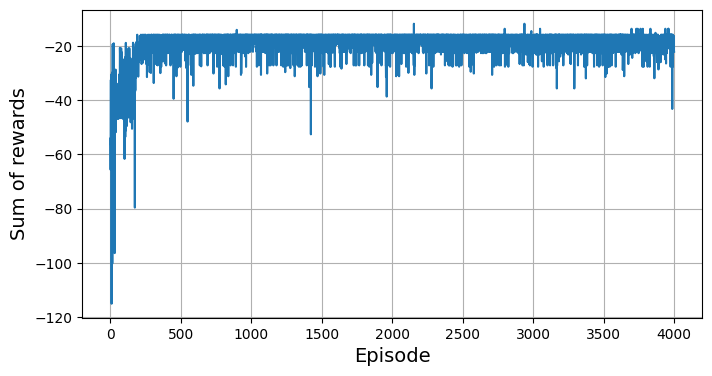

In [22]:
plt.figure(figsize=(8, 4))
plt.plot(ep_rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()